# Day 4 - calculation of statistical errors

## Point 1

**Block analysis** (Flyvbjerg, Petersen; JCP 1989) is a method used to correctly estimate the error on the mean in the case of correlated time series.

Recompute the average potential energies (column 3) as done in day 2 (for different temperatures from 0 to 3), together with the corresponding error on the mean estimated by the standard deviation (divided by square root of n. of samples) $\sigma_{\overline{x}}$. Remember to discard initial steps due to equilibration.

Then, write an algorithm to perform block analysis  and use it to correctly estimate the error on the mean. Does this estimate agree with the one determined at previous point?

Hint: focus firstly on the energies at a given temperature and perform block analysis by varying the block size (in logarithmic scale); plot the error as a function of the block size. What happens starting from block size = 1 and increasing it? Search for a plateau region, which identifies the optimal block size. Then, use this block size for all the temperatures (assumption); plot both $\sigma_{\overline{x}}$ and the error estimated with block analysis as a function of the temperature.

We assumed that the optimal block size is approximatively the same for all the temperatures. Is this assumption correct? For which temperatures it is not? Why?

Repeat block analysis for random white noise. What is the result of block analysis? Does it agree with the error on the mean estimated by the standard deviation $\sigma_{\overline{x}}$?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ene = {}
Ts = np.around(np.linspace(0.1, 3, 30), decimals=1)

for temp in Ts:
    # ene[temp] = np.loadtxt("Results/energiesT%.1f.dat" % temp)[1000:, 3][::10]
    ene[temp] = np.loadtxt('Energies/potential_energy_%.1f' % temp)[1000:]#[::10]

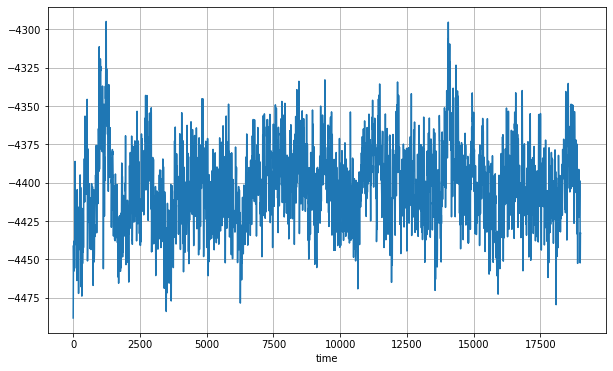

mean:  -4402.823911040737
std (on the mean):  [0.18288932]


In [3]:
temp = 0.8 # for example
energies = ene[temp]

plt.figure(figsize=(10, 6))
plt.plot(energies, '-')
plt.xlabel('time')
plt.grid()
plt.show()

size = np.shape(energies)
mean = np.mean(energies)
std = np.std(energies)

print('mean: ', mean)
print('std (on the mean): ', std/np.sqrt(size))

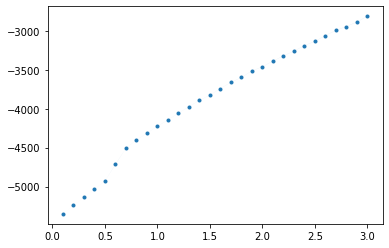

In [4]:
avs = []
stds = []

for temp in Ts:
    avs.append(np.mean(ene[temp]))
    stds.append(np.std(ene[temp])/np.sqrt(len(ene[temp])))

avs = np.array(avs)
stds = np.array(stds)

plt.plot(Ts, avs, '.')
plt.fill_between(Ts, avs - stds, avs + stds, alpha=0.5)
plt.xlabel('temperature')
plt.ylabel('average energy')

Due to correlations, the standard deviation (divided by the square root of n. of points in the sample) underestimates the uncertainty on the mean. In these cases, we should perform block analysis.

- Write an algorithm that perform block analysis.

In [5]:
def block_analysis(x, size_blocks=None):
    
    size = len(x)
    mean = np.mean(x)
    std = np.std(x)/np.sqrt(size)

    delta = 1
    if size_blocks is None:
        size_blocks = np.arange(1, np.int64(size/2) + delta, delta)

    n_blocks = []
    epsilon = []

    for size_block in size_blocks:
        n_block = int(size/size_block)
        
        # a = 0 
        # for i in range(n_block):
        #     a += (np.mean(x[(size_block*i):(size_block*(i+1))]))**2
        # 
        # epsilon.append(np.sqrt((a/n_blocks[-1] - mean**2)/n_blocks[-1]))

        block_averages = []
        for i in range(n_block):
            block_averages.append(np.mean(x[(size_block*i):(size_block*(i+1))]))
        block_averages = np.array(block_averages)

        n_blocks.append(n_block)
        epsilon.append(np.sqrt((np.mean(block_averages**2)-np.mean(block_averages)**2)/n_block))
    
    return mean, std, epsilon, n_blocks, size_blocks

In [6]:
mean, std, epsilon, n_blocks, size_blocks = block_analysis(energies)

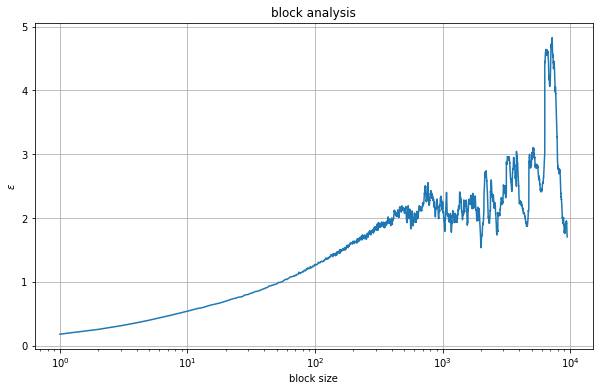

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(size_blocks, epsilon, '-')
plt.title('block analysis')
plt.xlabel('block size')
plt.ylabel('$\epsilon$')
plt.xscale('log')
# plt.yscale('log')
plt.grid()

Comments:
- when the block size is 1, we go back to standard deviation on the mean, which underestimates the actual error;
- then, increasing the block size the error on the mean increases, up to a platau region when it stabilizes (around 1000, depending on the stride);
- finally, the block size increased too much and the n. of blocks is too small to have a statistical significative estimate of the error.

Let's take the error corresponding at block size around 1000 (100 with stride 10).

In [8]:
size_block = 1000

In [9]:
index = np.argwhere(size_blocks == size_block)[0][0]
error = epsilon[index]

print('Standard deviation on the mean: ', std)
print('Correct estimate of the error on the mean: ', error)

Standard deviation on the mean:  0.18288931696569197
Correct estimate of the error on the mean:  2.157025894555502


Use this value of the block size for all the temperatures.

In [10]:
means = []
stds = []
epsilons = []

for temp in Ts:

    x = ene[temp]
    out = block_analysis(x, [size_block])

    means.append(out[0])
    stds.append(out[1])
    epsilons.append(out[2][0])

epsilons = np.array(epsilons)

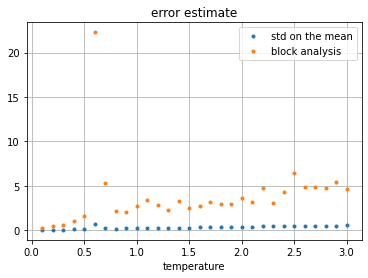

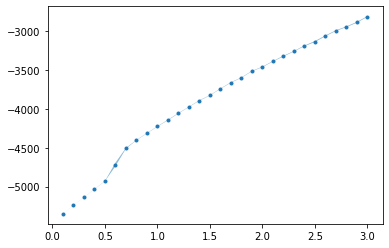

In [11]:
plt.figure()

plt.plot(Ts, stds, '.', label='std on the mean')
plt.plot(Ts, epsilons, '.', label='block analysis')

plt.xlabel('temperature')
plt.title('error estimate')
plt.legend()
plt.grid()

plt.figure()
plt.plot(Ts, avs, '.')
# plt.fill_between(Ts, avs - stds, avs + stds, alpha=0.5)
plt.fill_between(Ts, avs - epsilons, avs + epsilons, alpha=0.5)
plt.xlabel('temperature')
plt.ylabel('average energy')

Check on the optimal block size for all the temperatures

In [12]:
epsilon_check = {}

for temp in Ts:
    out = block_analysis(ene[temp])
    epsilon_check[temp] = out[2]

size_blocks = out[4]

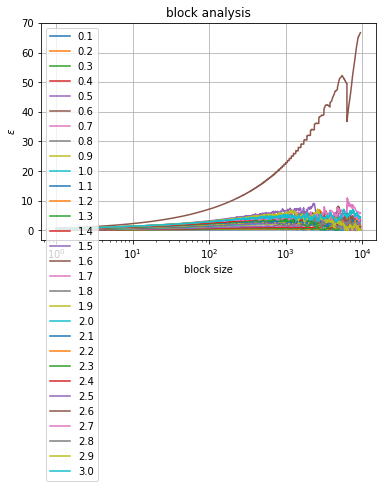

In [13]:
for temp in Ts:
    # plt.figure()
    # plt.plot(size_blocks, epsilon_more[temp]/epsilon_more[temp][0], '-', label=temp)
    plt.plot(size_blocks, epsilon_check[temp], '-', label=temp)
    # plt.xscale('log')
    # plt.title(temp)

plt.title('block analysis')
plt.xlabel('block size')
plt.ylabel('$\epsilon$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.grid()

Close to the transition temperature, we do not observe any plateau, this is due to wide fluctuations of the energy (transition from crystal to liquid phase).

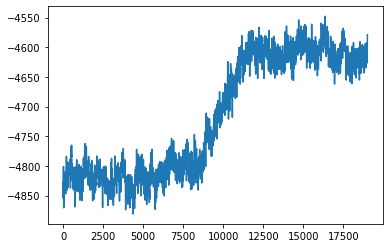

In [16]:
plt.plot(ene[0.6], '-')
plt.title('energy')
plt.xlabel('time')

Compare with white noise (uncorrelated)

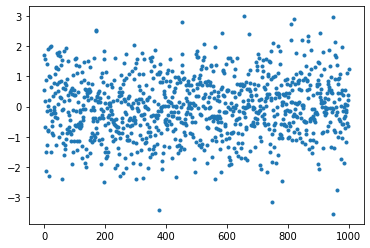

In [137]:
N = 1000
std = 1.0

white_noise = np.random.normal(scale=std, size=N) # by default, average 0 and std (scale) 1

plt.plot(white_noise, '.')
plt.show()

In [138]:
mean, std_onmean, epsilon, n_blocks, size_blocks = block_analysis(white_noise)

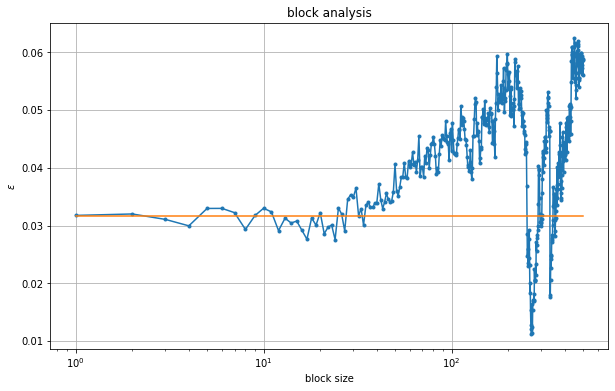

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(size_blocks, epsilon, '.-')
plt.plot([size_blocks[0], size_blocks[-1]], [std/np.sqrt(N), std/np.sqrt(N)], '-')
plt.title('block analysis')
plt.xlabel('block size')
plt.ylabel('$\epsilon$')
plt.xscale('log')
plt.grid()

## Point 2

**Bootstrap** (Efron, 1979) is a procedure to compute properties of an estimator by random re-sampling with replacement from the data. Write an algorithm to perform boostrap on blocks:
1. split your time series into $N$ (consecutive and disjoint) blocks, as done in block analysis (use the optimal $N$ you have got in the previous point);
2. generate a dummy trajectory by randomly sampling $N$ blocks with replacement (so that the trajectory has the same length as the original one) and use it to compute your quantity of interest (such as the mean energy or the heat capacity);
3. repeat 2nd step several times, then take average and standard deviation of the computed values; the standard deviation will estimate the uncertainty on the average value.

Use your algorithm to compute the error on the mean of the potential energy, as done in the previous point. Does this estimate agree with the previous one? Plot the two estimates as a function of the temperature.

Now, use your algorithm to compute the statistical error on the heat capacity, computed from fluctuations of the potential energy. Compare with the calculation of the heat capacity given by the derivative of the energy with respect to the temperature, approximated through finite difference.

What happens if you neglected to remove initial equilibration steps? 

Finally, compare these values of heat capacity with those obtained by analysing the trajectories generated starting from the equilibrium configuration at $T=3$ (hysteresis cycle). Where do you observe significative discrepancies? For such temperatures, did you correctly estimate the statistical error on the specific heat?

In [14]:
def bootstrap_on_blocks(x, n_block=10, n_repetitions=100, func='mean'):

    size_block = np.int64(len(x)/n_block)
    upto = n_block*size_block

    x_reshaped = np.reshape(x[:upto], (n_block, size_block))

    observables = []

    for i in range(n_repetitions):

        blocks_chosen = np.random.randint(n_block, size=n_block)
        traj = np.concatenate(x_reshaped[blocks_chosen])
        
        if func == 'mean':
            observables.append(np.mean(traj))
        else:
            observables.append(func(traj))

    mean = np.mean(observables)
    error = np.std(observables)

    return observables, mean, error

In [15]:
n_block = np.int64(len(energies)/size_block)
print('n. of blocks: ', n_block)

observables, mean, error = bootstrap_on_blocks(energies, n_block=n_block, func='mean')

n. of blocks:  19


-4402.754808826323 2.104414196577675


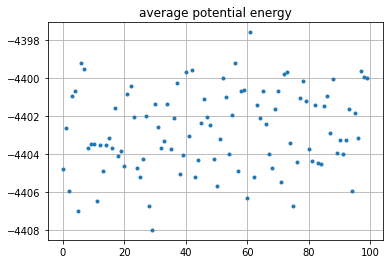

In [16]:
plt.plot(observables, '.')

plt.title('average potential energy')
plt.grid()

print(mean, error)

In [17]:
observables_list = []
mean_list = []
error_list = []

for temp in Ts:
    energies = ene[temp]
    out = bootstrap_on_blocks(energies, n_block=n_block, func='mean', n_repetitions=500)

    observables_list.append(out[0])
    mean_list.append(out[1])
    error_list.append(out[2])

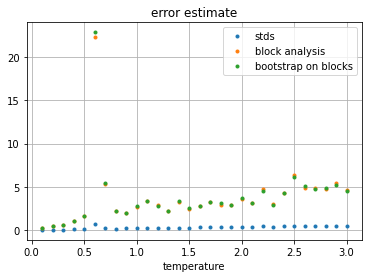

In [18]:
plt.plot(Ts, stds, '.', label='stds')
plt.plot(Ts, epsilons, '.', label='block analysis')
plt.plot(Ts, error_list, '.', label='bootstrap on blocks')

plt.legend()
plt.grid()
plt.title('error estimate')
plt.xlabel('temperature')
plt.show()

Now, compute the error on the heat capacity

In [19]:
func = lambda x: np.std(x)**2

5218.839263962988 232.5403059137789


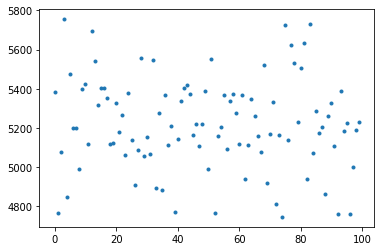

In [20]:
observables, mean, error = bootstrap_on_blocks(ene[temp], n_block=n_block, func=func)

plt.plot(observables, '.')

print(mean, error)

In [21]:
means = []
errors = []

for temp in Ts:
    out = bootstrap_on_blocks(ene[temp], n_block=10, func=func)
    means.append(out[1]/temp**2)
    errors.append(out[2]/temp**2)

means = np.array(means)
errors = np.array(errors)

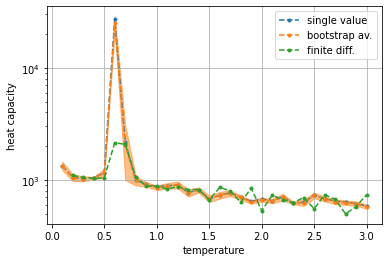

In [22]:
energy_var = []
energy_mean = []

for temp in Ts:
    energy_var.append(np.std(ene[temp])**2)
    energy_mean.append(np.mean(ene[temp]))

Cv = energy_var/Ts**2
plt.plot(Ts, Cv, '.--', label='single value')

plt.plot(Ts, means, '.--', label='bootstrap av.')

plt.fill_between(Ts, means - errors, means + errors, alpha=0.5, color='tab:orange')

Cv_finite_diff = np.ediff1d(energy_mean)/np.ediff1d(Ts)
plt.plot(Ts[1:], Cv_finite_diff, '.--', label='finite diff.')

plt.xlabel('temperature')
plt.ylabel('heat capacity')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

If you forgot to discard equilibration steps:

In [29]:
wrong_ene = {}
Ts = np.around(np.linspace(0.1, 3, 30), decimals=1)

for temp in Ts:
    wrong_ene[temp] = np.loadtxt('Energies/potential_energy_%.1f' % temp)

11028.98421911604 5896.952838048487


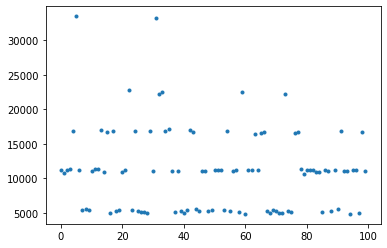

In [30]:
observables, wrong_mean, wrong_error = bootstrap_on_blocks(wrong_ene[temp], n_block=10, func=func)

plt.plot(observables, '.')

print(wrong_mean, wrong_error)

In [31]:
wrong_means = []
wrong_errors = []

for temp in Ts:
    out = bootstrap_on_blocks(wrong_ene[temp], n_block=10, func=func)
    wrong_means.append(out[1]/temp**2)
    wrong_errors.append(out[2]/temp**2)

wrong_means = np.array(wrong_means)
wrong_errors = np.array(wrong_errors)

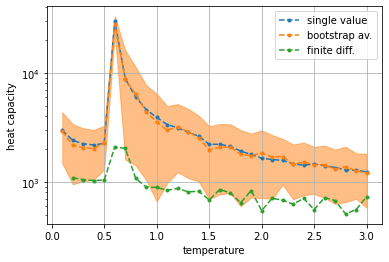

In [32]:
wrong_energy_var = []
wrong_energy_mean = []

for temp in Ts:
    wrong_energy_var.append(np.std(wrong_ene[temp])**2)
    wrong_energy_mean.append(np.mean(wrong_ene[temp]))

wrong_Cv = wrong_energy_var/Ts**2
plt.plot(Ts, wrong_Cv, '.--', label='single value')

plt.plot(Ts, wrong_means, '.--', label='bootstrap av.')

plt.fill_between(Ts, wrong_means - wrong_errors, wrong_means + wrong_errors, alpha=0.5, color='tab:orange')

wrong_Cv_finite_diff = np.ediff1d(wrong_energy_mean)/np.ediff1d(Ts)
plt.plot(Ts[1:], wrong_Cv_finite_diff, '.--', label='finite diff.')

plt.xlabel('temperature')
plt.ylabel('heat capacity')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

Now, use the trajectories generated starting from the equilibrium configuration at $T=3$.

In [23]:
ene_back = {}

# Ts_back = np.around(np.concatenate((np.linspace(0.1, 1, 10), np.linspace(1.5, 3, 4))), decimals=1)
# Ts_back = np.array(list(np.around(np.linspace(0.1, 1, 10), decimals=1)) + [1.5, 2.0, 2.5, 3.0])
Ts_back = list(np.around(np.linspace(0.1, 1, 10), decimals=1)) + [1.5, 2.0, 2.5, 3.0]
Ts_back = np.array(Ts_back)

for temp in Ts_back:
    # ene_back[temp] = np.loadtxt("../Results/point3/energiesT%.1f.dat" % temp)[:,3]#[1000:, 3][::10]
    ene_back[temp] = np.loadtxt('Energies/potential_energy_back_%.1f' % temp)[1000:]#[::10]

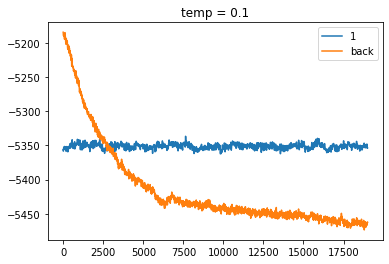

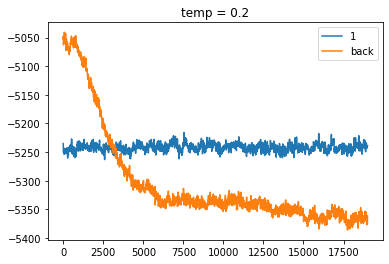

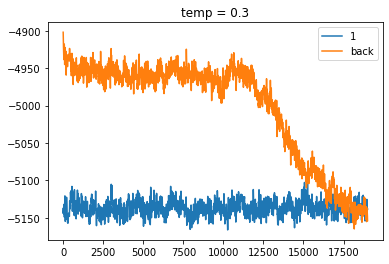

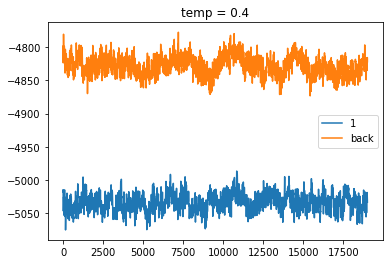

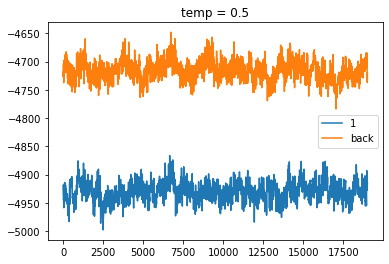

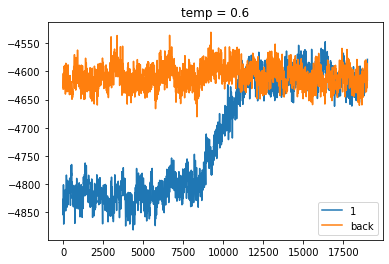

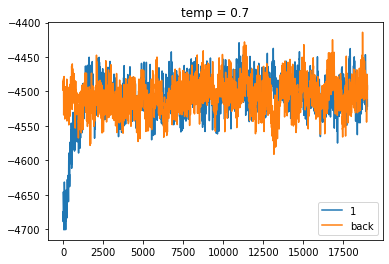

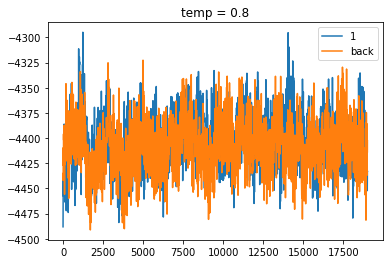

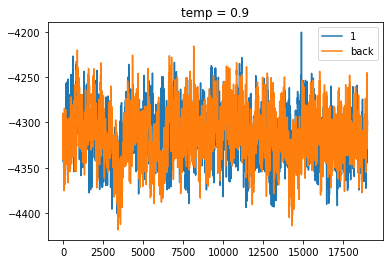

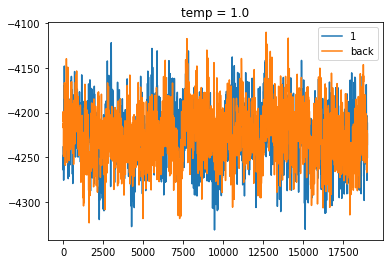

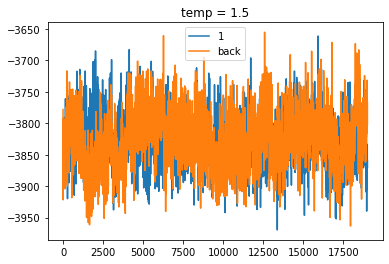

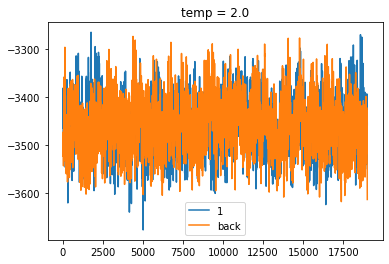

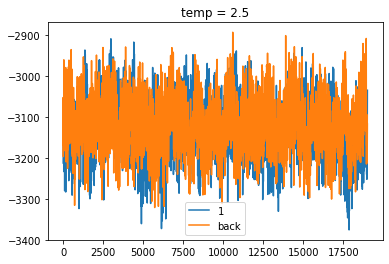

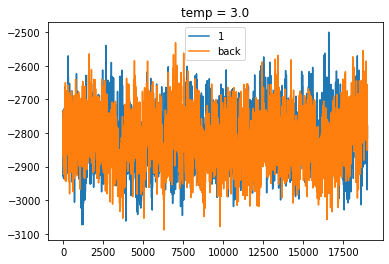

In [24]:
for k in ene_back.keys():
    plt.figure()
    plt.plot(ene[k], label='1')
    plt.plot(ene_back[k], label='back')
    plt.title('temp = %s' % k)
    plt.legend()

In [25]:
means_back = []
errors_back = []

for temp in Ts_back:
    out = bootstrap_on_blocks(ene_back[temp], n_block=10, func=func)
    means_back.append(out[1]/temp**2)
    errors_back.append(out[2]/temp**2)

means_back = np.array(means_back)
errors_back = np.array(errors_back)

In [26]:
energy_back_var = []
energy_back_mean = []

for temp in Ts_back:
    energy_back_var.append(np.std(ene_back[temp])**2)
    energy_back_mean.append(np.mean(ene_back[temp]))

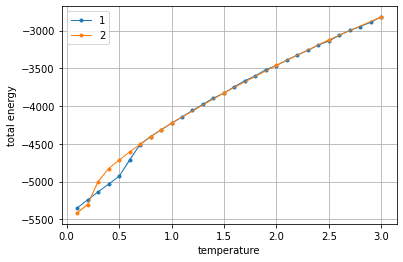

In [27]:
plt.plot(Ts, energy_mean, '.-', linewidth=1, label='1')
# plt.errorbar(Ts, energy_mean, np.sqrt(energy_var))
error_list = np.array(error_list)
plt.fill_between(Ts, energy_mean - error_list, energy_mean + error_list, alpha=0.3)

error_back_list = []
for temp in Ts_back:
    out = bootstrap_on_blocks(ene_back[temp], n_block=20, func='mean', n_repetitions=500)
    error_back_list.append(out[2])
error_back_list = np.array(error_back_list)

plt.plot(Ts_back, energy_back_mean, '.-', linewidth=1, label='2')
# plt.errorbar(Ts2, energy2_mean, np.sqrt(energy2_var))
plt.fill_between(Ts_back, energy_back_mean - error_back_list, energy_back_mean + error_back_list, alpha=0.3)

plt.grid()
plt.xlabel('temperature')
plt.ylabel('total energy')
# plt.xlim([0, 1])
# plt.gca().set_ylim(top=-1000)
plt.legend()
plt.show()

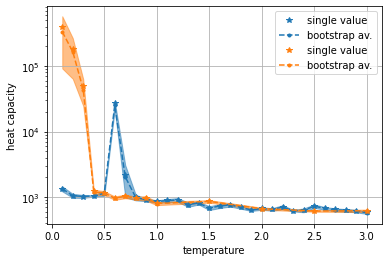

In [28]:
Cv = energy_var/Ts**2
plt.plot(Ts, Cv, '*', label='single value', color='tab:blue')

plt.plot(Ts, means, '.--', label='bootstrap av.', color='tab:blue')

plt.fill_between(Ts, means - errors, means + errors, alpha=0.5, color='tab:blue')

Cv_findiff = np.ediff1d(energy_mean)/np.ediff1d(Ts)
# plt.plot(Ts[1:], Cv_findiff, '.--', label='finite diff.')
# plt.fill_between(Ts[1:], Cv_findiff - epsilon_sum, Cv_findiff + epsilon_sum, alpha=0.5)

# back
Cv_back = energy_back_var/Ts_back**2
plt.plot(Ts_back, Cv_back, '*', label='single value', color='tab:orange')

plt.plot(Ts_back, means_back, '.--', label='bootstrap av.', color='tab:orange')

plt.fill_between(Ts_back, means_back - errors_back, means_back + errors_back, alpha=0.5, color='tab:orange')

Cv_back_findiff = np.ediff1d(energy_back_mean)/np.ediff1d(Ts_back)
# plt.plot(Ts_back[1:], Cv_back_findiff, '.--', label='finite diff.')
# plt.fill_between(Ts[1:], Cv_findiff - epsilon_sum, Cv_findiff + epsilon_sum, alpha=0.5)

plt.xlabel('temperature')
plt.ylabel('heat capacity')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [73]:
errors_back

array([2.42111384e+05, 1.01667274e+05, 1.91875602e+04, 1.00463477e+02,
       8.20759021e+01, 5.64098385e+01, 6.64509244e+01, 4.52392044e+01,
       7.86929087e+01, 4.40960429e+01, 3.78092774e+01, 2.52151273e+01,
       1.50653984e+01, 2.66141172e+01])

Where the assumption on same block size for all the temperatures fails:

In [30]:
n_blocks# = out[3]

[19000,
 9500,
 6333,
 4750,
 3800,
 3166,
 2714,
 2375,
 2111,
 1900,
 1727,
 1583,
 1461,
 1357,
 1266,
 1187,
 1117,
 1055,
 1000,
 950,
 904,
 863,
 826,
 791,
 760,
 730,
 703,
 678,
 655,
 633,
 612,
 593,
 575,
 558,
 542,
 527,
 513,
 500,
 487,
 475,
 463,
 452,
 441,
 431,
 422,
 413,
 404,
 395,
 387,
 380,
 372,
 365,
 358,
 351,
 345,
 339,
 333,
 327,
 322,
 316,
 311,
 306,
 301,
 296,
 292,
 287,
 283,
 279,
 275,
 271,
 267,
 263,
 260,
 256,
 253,
 250,
 246,
 243,
 240,
 237,
 234,
 231,
 228,
 226,
 223,
 220,
 218,
 215,
 213,
 211,
 208,
 206,
 204,
 202,
 200,
 197,
 195,
 193,
 191,
 190,
 188,
 186,
 184,
 182,
 180,
 179,
 177,
 175,
 174,
 172,
 171,
 169,
 168,
 166,
 165,
 163,
 162,
 161,
 159,
 158,
 157,
 155,
 154,
 153,
 152,
 150,
 149,
 148,
 147,
 146,
 145,
 143,
 142,
 141,
 140,
 139,
 138,
 137,
 136,
 135,
 134,
 133,
 132,
 131,
 131,
 130,
 129,
 128,
 127,
 126,
 125,
 125,
 124,
 123,
 122,
 121,
 121,
 120,
 119,
 118,
 118,
 117,
 116,
 1

In [31]:
len(n_blocks)

9500

In [77]:
stride = 5

errors_2check = {}
errors_2check_back = {}

for temp in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:

    errors_2check[temp] = []

    for n_block in n_blocks[::stride]:
        out = bootstrap_on_blocks(ene[temp], n_block=n_block, func=func) # func=func or func='mean'
        errors_2check[temp].append(out[2]/temp**2)

    errors_2check_back[temp] = []

    for n_block in n_blocks[::stride]:
        out = bootstrap_on_blocks(ene_back[temp], n_block=n_block, func=func) # func=func or func='mean'
        errors_2check_back[temp].append(out[2]/temp**2)

In [78]:
print(errors, errors_back)

[ 118.20505507   72.02196539   53.87392097   23.15470406  108.54340335
 3558.30688497 1043.39002365   97.05001041   42.86106872   40.83427864
   50.42713086   62.75797278   58.78654823   41.60030719   45.72006004
   51.4293769    44.09342399   32.59848475   22.68826211   27.57778819
   30.39113127   48.24137198   17.15202668   42.17172666   43.15734485
   31.70197181   33.3274417    28.87540924   28.47741519   24.00587582] [2.42111384e+05 1.01667274e+05 1.91875602e+04 1.00463477e+02
 8.20759021e+01 5.64098385e+01 6.64509244e+01 4.52392044e+01
 7.86929087e+01 4.40960429e+01 3.78092774e+01 2.52151273e+01
 1.50653984e+01 2.66141172e+01]


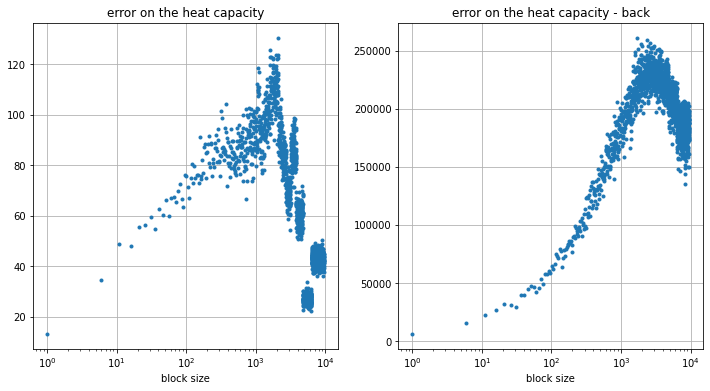

In [110]:
temp = 0.1

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(size_blocks[::stride], errors_2check[temp], '.')
plt.xscale('log')
plt.grid()
plt.xlabel('block size')
plt.title('error on the heat capacity')

plt.subplot(1, 2, 2)
plt.plot(size_blocks[::stride], errors_2check_back[temp], '.')
plt.xscale('log')
plt.grid()
plt.xlabel('block size')
plt.title('error on the heat capacity - back')

plt.show()